#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
#!pip install -q tqdm
#!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
#from PIL import Image
#import IPython.display
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score
import gdown


# Дополнительнные модули (made by Sokol Stepan)
#import tensorflow. as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.applications import MobileNetV2
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout, Flatten, BatchNormalization 
from keras.models import Sequential, load_model
from keras import Model
from keras.optimizers import RMSprop, Adam
from keras.regularizers import L1, L2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers.attention.multi_head_attention import activation
from keras.preprocessing.image import ImageDataGenerator
import pickle

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [5]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        try:
          url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
          output = f'{name}.npz'
          gdown.download(url, output, quiet=False)
          print(f'Loading dataset {self.name} from npz.')
        except: 
          print("Вредный коллаб запрещает качать данные")
        np_obj = np.load(f'{name}.npz')
        # ВНЕСЕНО ИЗМЕНЕНИЕ В КЛАСС: ПЕРЕВОД ТРЕХКАНАЛЬНЫХ ЦВЕТНЫХ СНИМКОВ
        # В ГРАДАЦИИ СЕРОГО ДЛЯ ЭКОНОМИИ ОПЕРАТИВНОЙ ПАМЯТИ. 
        self.images = np.mean(np_obj['data'], axis=3)[...,np.newaxis]
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

In [6]:
#d_train_tiny = Dataset('test_small')

#img, lbl = d_train_tiny.random_image_with_label()
#print()
#print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
#print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

#pil_img = Image.fromarray(img)
#IPython.display.display(pil_img)
#d_train_tiny.images.shape

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [7]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))
        #LBL4 Построение матрицы ошибок, оценивание чувствительности и специфичности модели
        print('\t precision {:.4f}:'.format(precision_score(gt, pred, average='weighted')))
        print('\t recall {:.4f}:'.format(recall_score(gt, pred, average='weighted')))
        ConfusionMatrixDisplay.from_predictions(gt, pred)


---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

### Результаты разных сетей

In [8]:
#    def __init__(self):
#        super(Model_, self).__init__()
#        self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
#        self.do1 = Dropout(rate=0.5)
#        self.fl  = Flatten()
#        self.dense2 = Dense(9, activation='softmax')

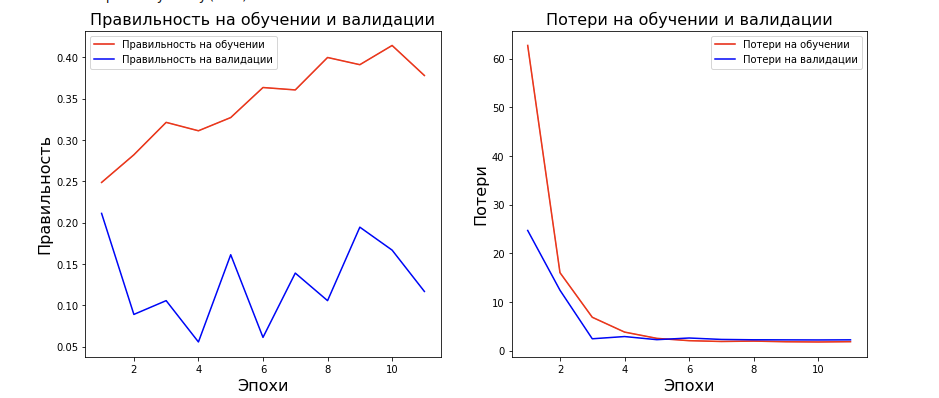

In [9]:
#    def __init__(self):
#        super(Model_, self).__init__()
#        self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
#        self.do1 = Dropout(rate=0.25)
#        self.fl  = Flatten()
#        self.dense2 = Dense(9, activation='softmax')

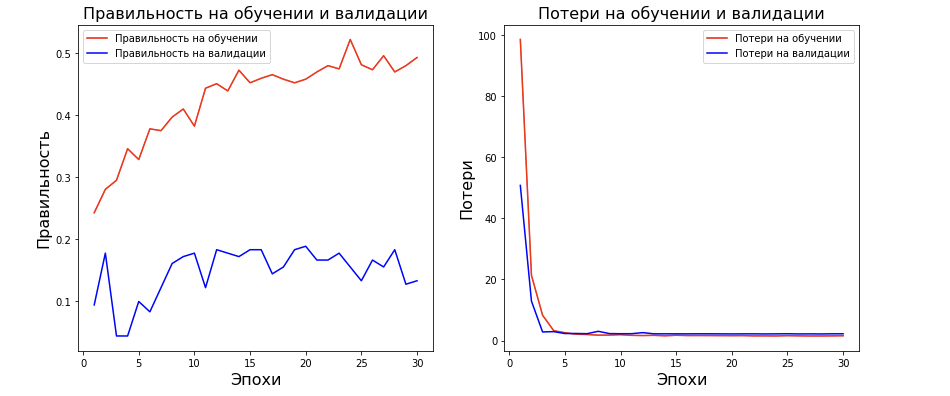

In [10]:
 #   def __init__(self):
 #       super(Model_, self).__init__()
 #       self.conv1 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
 #       self.do1 = Dropout(rate=0.25)
 #       self.fl  = Flatten()
 #       self.dense2 = Dense(9, activation='softmax')

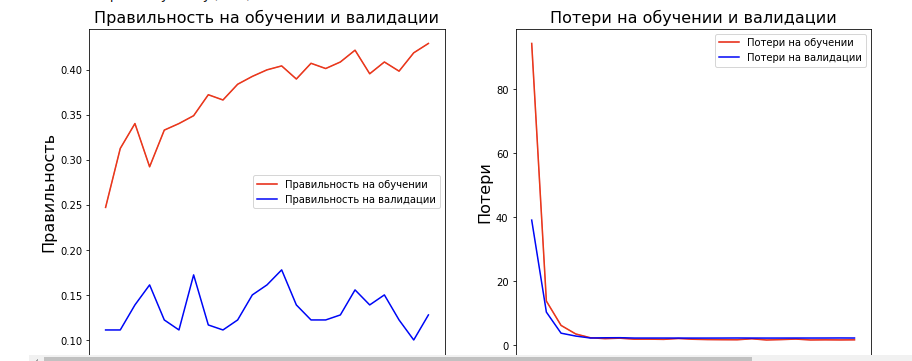

In [11]:
 #   def __init__(self):
 #       super(Model_, self).__init__()
 #       self.conv1 = Conv2D(filters=8, kernel_size=3, strides=1, activation="relu")
 #       self.conv2 = Conv2D(filters=8, kernel_size=3, strides=1, activation="relu")
 #       self.do1 = Dropout(rate=0.25)
 #       self.fl  = Flatten()
 #       self.dense2 = Dense(9, activation='softmax')

![image.png](
  
)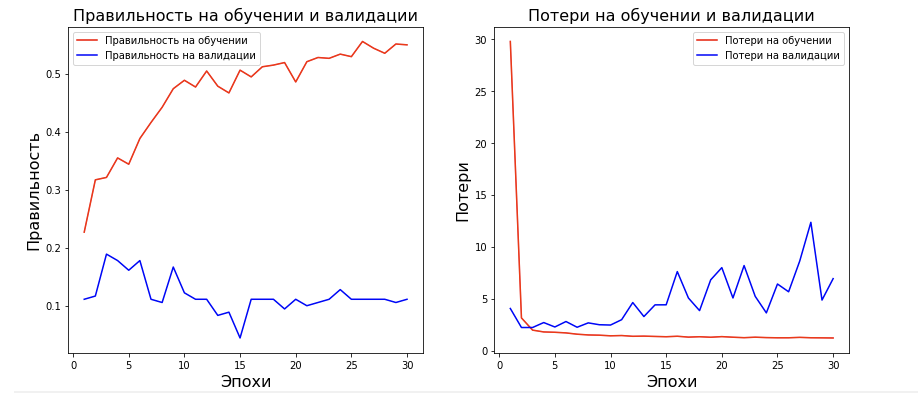

In [12]:
#    def __init__(self):
#        super(Model_, self).__init__()
#        self.conv1 = Conv2D(filters=8, kernel_size=3, strides=1, activation="relu")
#        self.conv2 = Conv2D(filters=16, kernel_size=3, strides=1, activation="relu")
#        self.do1 = Dropout(rate=0.25)
#        self.fl  = Flatten()
#        self.dense2 = Dense(9, activation='softmax')

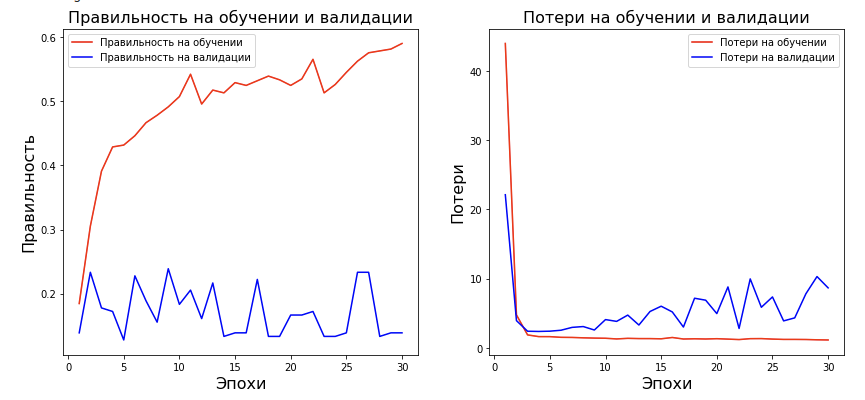

In [13]:
#    def __init__(self):
#        super(Model_, self).__init__()
#        self.conv1 = Conv2D(filters=16, kernel_size=3, strides=1, activation="relu")
#        self.conv2 = Conv2D(filters=16, kernel_size=3, strides=1, activation="relu")
#        self.do1 = Dropout(rate=0.25)
#        self.fl  = Flatten()
#        self.dense2 = Dense(9, activation='softmax')

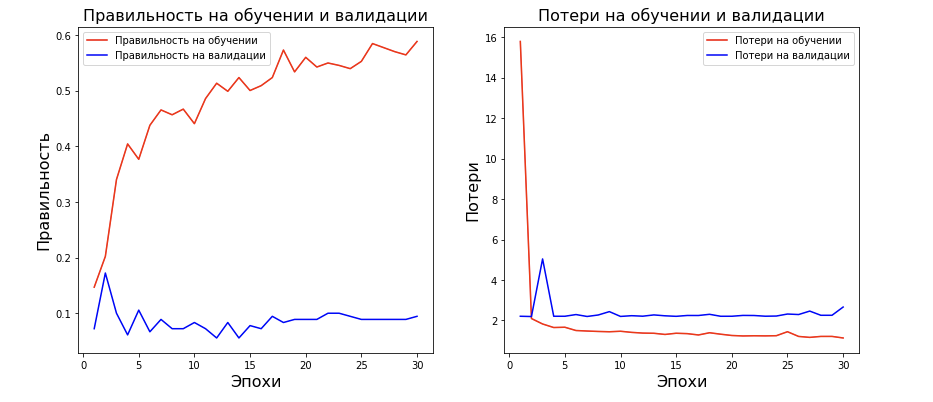

In [14]:
#    def __init__(self):
#        super(Model_, self).__init__()
#        self.conv1 = Conv2D(filters=8, kernel_size=3, strides=1, activation="relu")
#        self.conv2 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
#        self.do1 = Dropout(rate=0.25)
#        self.fl  = Flatten()
#        self.dense2 = Dense(9, activation='softmax')

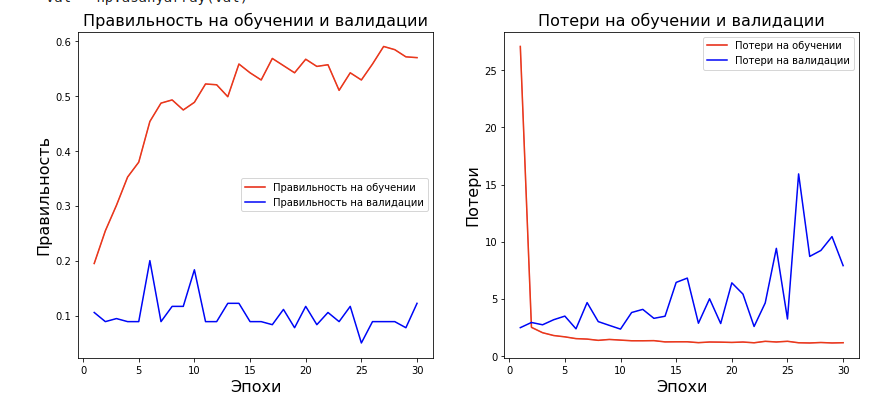

In [15]:
#    def __init__(self):
#        super(Model_, self).__init__()
#        self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
#        self.max1 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
#        self.max2 =  MaxPooling2D(pool_size=(2, 2))
#        self.fl  = Flatten()
#        self.do1 = Dropout(rate=0.25)
#        self.dense2 = Dense(9, activation='softmax')

# Внесена Стратификация в train test split, отключены аугментации кроме флипов

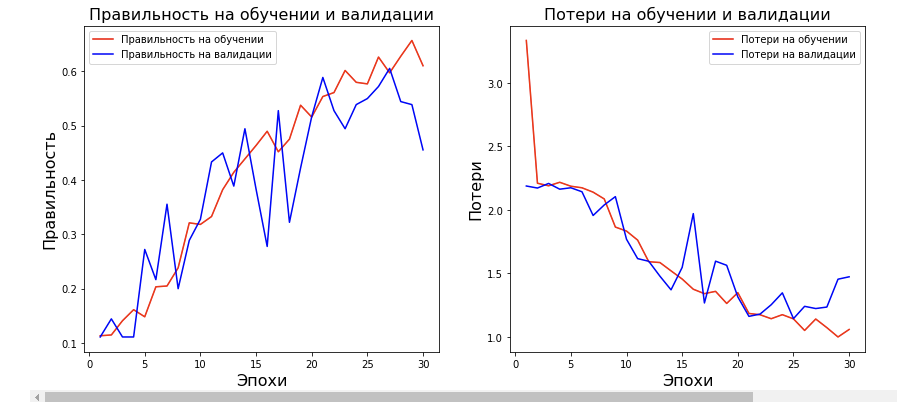

In [16]:
#    def __init__(self):
#        super(Model_, self).__init__()
#        self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
#        self.max1 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
#        self.max2 =  MaxPooling2D(pool_size=(2, 2))
#        self.fl  = Flatten()
#        self.do1 = Dropout(rate=0.25)
#        self.dense2 = Dense(9, activation='softmax')

# та же сеть, что и выше, только с внесенным шедулером по шагу обучения от 0.001 до 1е-7

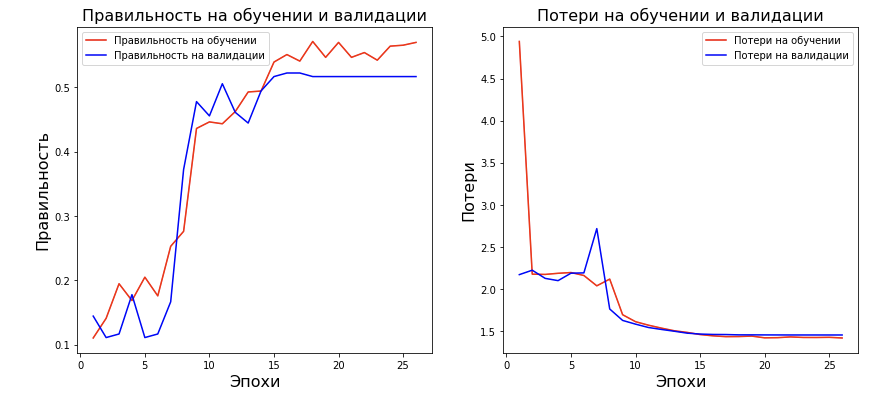

In [17]:
 #   def __init__(self):
 #       super(Model_, self).__init__()
 #       self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
 #       self.max1 =  MaxPooling2D(pool_size=(2, 2))
 #       self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
 #       self.max2 =  MaxPooling2D(pool_size=(2, 2))
 #       self.conv3 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
 #       self.max3 =  MaxPooling2D(pool_size=(2, 2))
 #       self.fl  = Flatten()
 #       self.do1 = Dropout(rate=0.25)
 #       self.dense2 = Dense(9, activation='softmax')

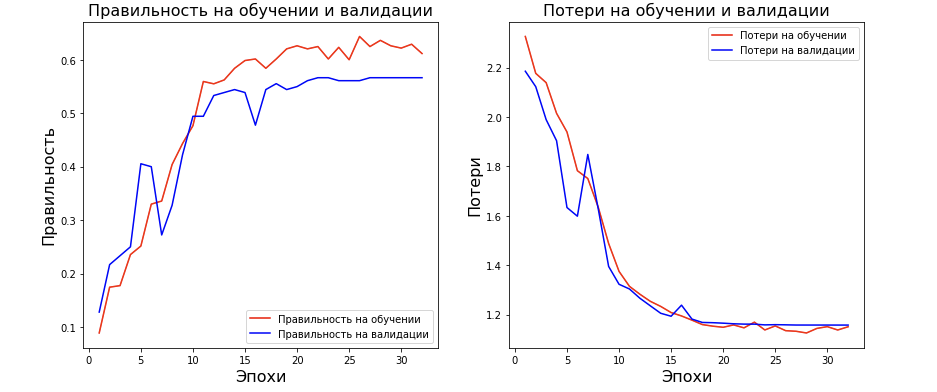

In [18]:
#    def __init__(self):
#        super(Model_, self).__init__()
#        self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
#        self.max1 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
#        self.max2 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv3 = Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")
#        self.max3 =  MaxPooling2D(pool_size=(2, 2))
#        self.fl  = Flatten()
#        self.do1 = Dropout(rate=0.25)
#        self.dense2 = Dense(9, activation='softmax')

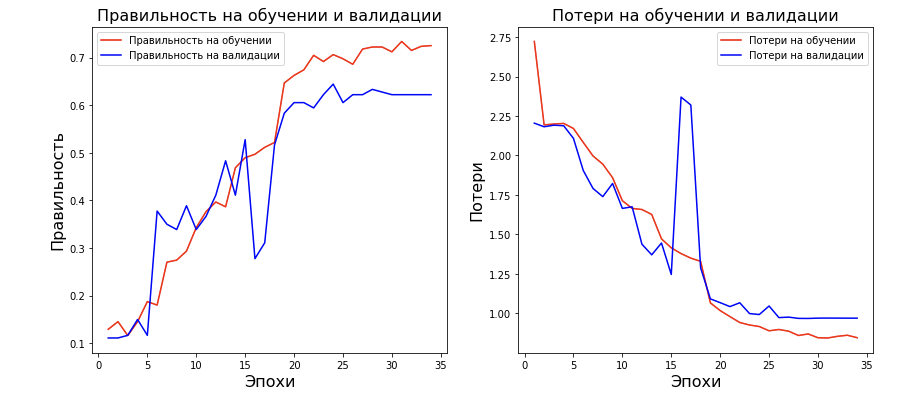

In [19]:
#    def __init__(self):
#        super(Model_, self).__init__()
#       self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
#        self.max1 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
#        self.max2 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv3 = Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")
#        self.conv4 = Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")
#        self.max3 =  MaxPooling2D(pool_size=(2, 2))
#        self.fl  = Flatten()
#        self.do1 = Dropout(rate=0.25)
#        self.dense2 = Dense(9, activation='softmax')
# Качество 0.65
#Начинается уплотнение, двойные слои свертки

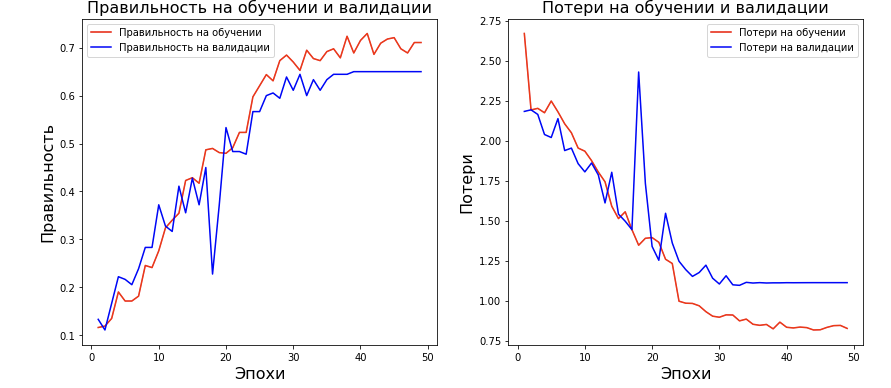

In [20]:
#    def __init__(self):
#        super(Model_, self).__init__()
#        self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
#        self.max1 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
#        self.conv3 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
#        self.max2 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv4 = Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")
#        self.conv5 = Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")
#        self.max3 =  MaxPooling2D(pool_size=(2, 2))
#        self.fl  = Flatten()
#        self.do1 = Dropout(rate=0.25)
#        self.dense2 = Dense(9, activation='softmax')
# Стало хуже. 0.48

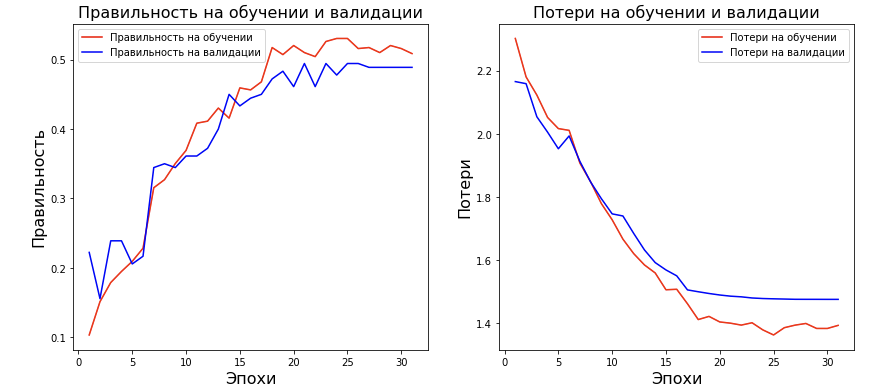

In [21]:
#    def __init__(self):
#        super(Model_, self).__init__()
#        self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
#        self.max1 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
#        self.max2 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv3 = Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")
#        self.max3 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv4 = Conv2D(filters=256, kernel_size=3, strides=1, activation="relu")
#        self.max4 =  MaxPooling2D(pool_size=(2, 2))
#        self.fl  = Flatten()
#        self.do1 = Dropout(rate=0.25)
#        self.dense2 = Dense(9, activation='softmax')
# Лучше не стало 0.62

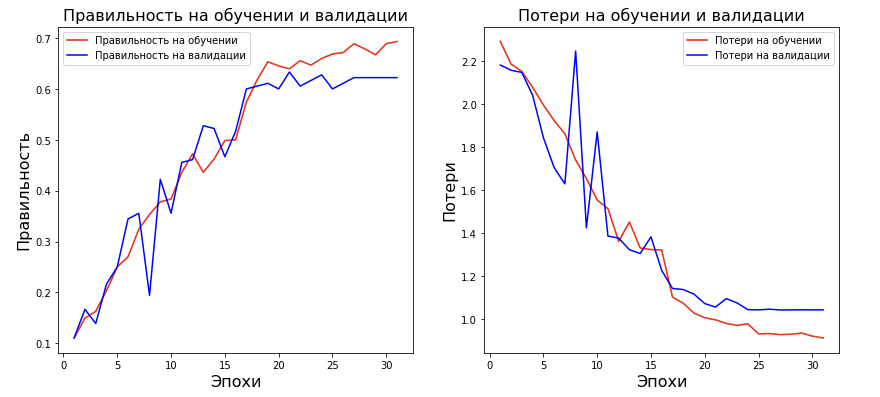

In [22]:
 #   def __init__(self):
 #       super(Model_, self).__init__()
 #       self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
 #       self.max1 =  MaxPooling2D(pool_size=(2, 2))
 #       self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
 #       self.max2 =  MaxPooling2D(pool_size=(2, 2))
 #       self.conv3 = Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")
 #       self.max3 =  MaxPooling2D(pool_size=(2, 2))
 #       self.conv4 = Conv2D(filters=256, kernel_size=3, strides=1, activation="relu")
 #       self.max4 =  MaxPooling2D(pool_size=(2, 2))
 #       self.fl  = Flatten()
 #       self.do1 = Dropout(rate=0.25)
 #       self.dense1 = Dense(512, activation='relu')
 #       self.dense2 = Dense(9, activation='softmax')
 # Стало лучше - 0.68. Шедулер подкручен на более плавное снижение шага обучения 0.5 
 # Добавлен полносвязный слой

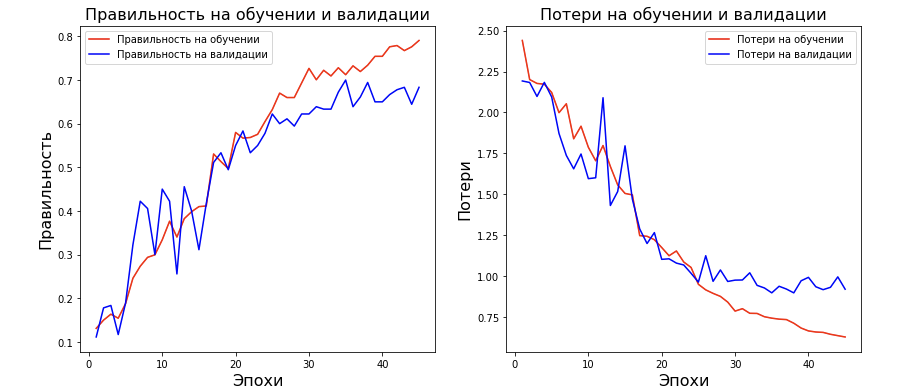

In [23]:
 #   def __init__(self):
 #       super(Model_, self).__init__()
 #       self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
 #       self.max1 =  MaxPooling2D(pool_size=(2, 2))
 #       self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
 #       self.max2 =  MaxPooling2D(pool_size=(2, 2))
 #       self.conv3 = Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")
 #       self.max3 =  MaxPooling2D(pool_size=(2, 2))
 #       self.conv4 = Conv2D(filters=256, kernel_size=3, strides=1, activation="relu")
 #       self.max4 =  MaxPooling2D(pool_size=(2, 2))
 #       self.conv4 = Conv2D(filters=512, kernel_size=3, strides=1, activation="relu")
 #       self.max4 =  MaxPooling2D(pool_size=(2, 2))
 #       self.fl  = Flatten()
 #       self.do1 = Dropout(rate=0.25)
 #       self.dense1 = Dense(512, activation='relu')
 #       self.dense2 = Dense(9, activation='softmax')

# Добавлен блок свертка-пулинг. Шедулер еще плавнее 0.75, больше эпох,качество стало 0.71

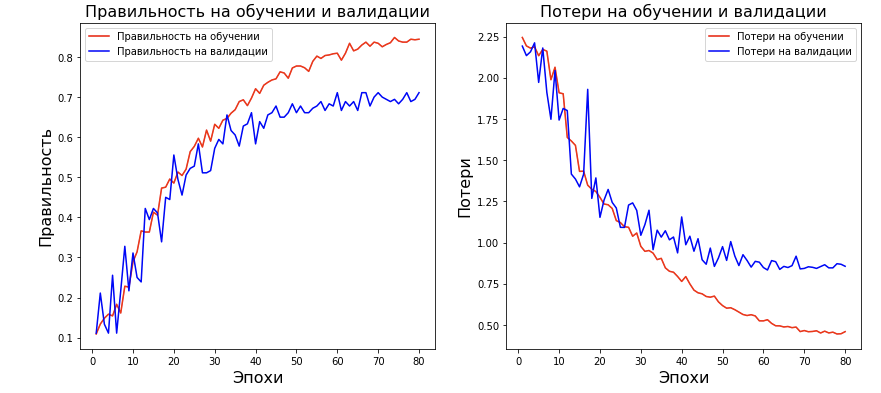

In [24]:
#    def __init__(self):
#        super(Model_, self).__init__()
#        self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
#        self.max1 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv5 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
#        self.max5 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
#        self.max2 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv3 = Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")
#        self.max3 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv4 = Conv2D(filters=512, kernel_size=3, strides=1, activation="relu")
#        self.max4 =  MaxPooling2D(pool_size=(2, 2))
#        self.fl  = Flatten()
#        self.do1 = Dropout(rate=0.25)
#        self.dense1 = Dense(512, activation='relu')
#        self.dense2 = Dense(9, activation='softmax')
# Продублирован первый блок свертка-пулинг. Стало лучше 0.74

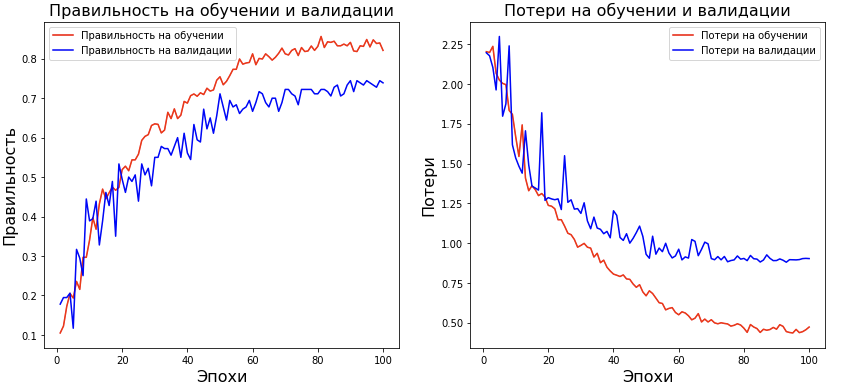

In [25]:
#    def __init__(self):
#        super(Model_, self).__init__()
#        self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
#        self.max1 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv5 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
#        self.max5 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
#        self.max2 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv3 = Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")
#        self.max3 =  MaxPooling2D(pool_size=(2, 2))
#        self.conv4 = Conv2D(filters=512, kernel_size=3, strides=1, activation="relu")
#        self.max4 =  MaxPooling2D(pool_size=(2, 2))
#        self.fl  = Flatten()
#        self.do1 = Dropout(rate=0.25)
#        self.dense1 = Dense(512, activation='relu')
#        self.dense2 = Dense(9, activation='softmax')
# Увеличена ротация до 50 градусов. Больше эпох. 
# Качество 0.85

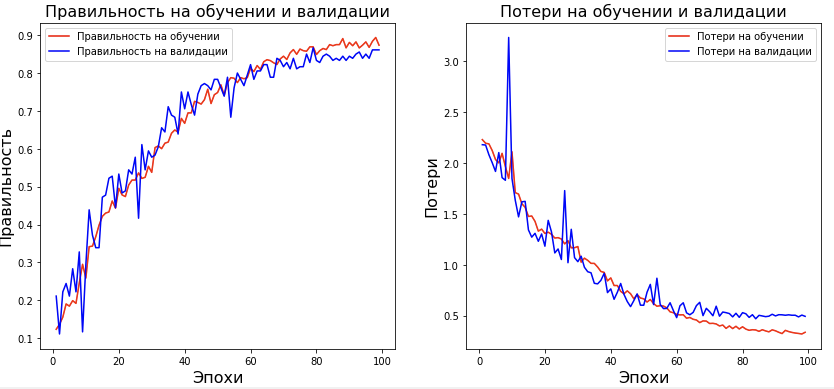

Код тот же, что и выше, но на больших данных (small) качество под 0.95

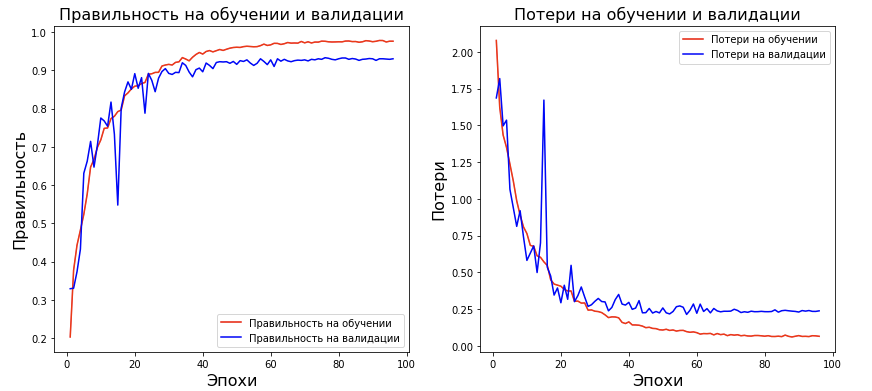

## Моделирование

In [26]:
class Model_(Model): # Попробуем за основу решения взять Tensorflow Keras

    def __init__(self):
        super(Model_, self).__init__()
        self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
        self.max1  =  MaxPooling2D(pool_size=(2, 2))
        self.bn1   = BatchNormalization()
        self.conv5 = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")
        self.max5  =  MaxPooling2D(pool_size=(2, 2))
        self.bn5   = BatchNormalization()
        self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")
        self.max2  =  MaxPooling2D(pool_size=(2, 2))
        self.bn2   = BatchNormalization()
        self.conv3 = Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")
        self.max3  =  MaxPooling2D(pool_size=(2, 2))
        self.bn3   = BatchNormalization()
        self.conv4 = Conv2D(filters=512, kernel_size=3, strides=1, activation="relu")
        self.max4 =  MaxPooling2D(pool_size=(2, 2))
        self.fl  = Flatten()
        self.do1 = Dropout(rate=0.25)
        self.dense1 = Dense(1024, activation='relu')
        self.dense2 = Dense(512, activation='relu')
        self.dense3 = Dense(9, activation='softmax')
        

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.bn1(x)
        x = self.conv5(x)
        x = self.max5(x)
        x = self.bn5(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.max3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.max4(x)
        x = self.fl(x)
        x = self.do1(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x
          

    def train(self, dataset: Dataset):
        X_train, X_valid, y_train, y_valid = train_test_split(dataset.images.astype('float32')/255., 
                                                              dataset.labels, 
                                                              test_size=0.15,
                                                              shuffle=True, 
                                                              stratify=dataset.labels)
        print(f'training started')
        datagen = ImageDataGenerator(
                rotation_range=50,
                horizontal_flip=True, vertical_flip=True)
        datagen.fit(X_train)

        #LBL5 - адаптивный шаг обучения при достижении плато по правильности
        scheduler = ReduceLROnPlateau(
                                    monitor="val_acc",
                                    factor=0.75,
                                    patience=3,
                                    verbose=0,
                                    mode="auto",
                                    min_delta=0.000001,
                                    cooldown=0,
                                    min_lr=0
                                )




        #LBL1 - реализация раннего прерывания обучения
        callback = EarlyStopping(monitor='val_acc', patience=20, verbose=1)

  
        self.compile(loss='sparse_categorical_crossentropy', 
                    metrics=['acc'],
                    optimizer=RMSprop(
                                      learning_rate=0.001,
                                      rho=0.9,
                                      momentum=0.2,
                                      epsilon=1e-07,
                                      centered=False,
                                      name="RMSprop",
                                    ))
        #LBL2 - Валидация модели на части обучающей выборки
        history = self.fit(
                           #X_train, y_train,
                           datagen.flow(X_train, y_train, batch_size=32),
                           steps_per_epoch=len(X_train) // 32,
                           epochs=150, 
                           callbacks=[callback, scheduler],
                           validation_data=(X_valid, y_valid))
        sleep(2)
        print(f'training done')
        history_dict = history.history
        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        accuracy = history_dict['acc']
        val_accuracy = history_dict['val_acc']
        
        epochs = range(1, len(loss_values) + 1)
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        #LBL3 Построение графиков, визуализирующих процесс обучения 
        # (график зависимости функции потерь от номера эпохи обучения, и т.п.)
        # График правильности по эпохам
        ax[0].plot(epochs, accuracy, 'r', label='Правильность на обучении')
        ax[0].plot(epochs, val_accuracy, 'b', label='Правильность на валидации')
        ax[0].set_title('Правильность на обучении и валидации', fontsize=16)
        ax[0].set_xlabel('Эпохи', fontsize=16)
        ax[0].set_ylabel('Правильность', fontsize=16)
        ax[0].legend()
        
        # График потерь по эпохам
        ax[1].plot(epochs, loss_values, 'r', label='Потери на обучении')
        ax[1].plot(epochs, val_loss_values, 'b', label='Потери на валидации')
        ax[1].set_title('Потери на обучении и валидации', fontsize=16)
        ax[1].set_xlabel('Эпохи', fontsize=16)
        ax[1].set_ylabel('Потери', fontsize=16)
        ax[1].legend()
        
        
    def test_on_dataset(self, dataset: Dataset):
        X_test = dataset.images.astype('float32')/255.0
        preds = self.predict(X_test)
        preds = np.argmax(preds, axis=1)
        return preds

    def save_(self, name: str): # попробовать пикл
        with open(f'/content/drive/MyDrive/{name}.pickle', 'wb') as f:
          pickle.dump(self, f)
        print('Model saved')
        #self.save(f'/content/drive/MyDrive/{name}', save_format='tf')

        


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [27]:
d_train = Dataset('train_small')
d_test = Dataset('test_small')
print(len(d_train.images))

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR
To: /content/train_small.npz
100%|██████████| 841M/841M [00:08<00:00, 100MB/s] 


Loading dataset train_small from npz.
Done. Dataset train_small consists of 7200 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI
To: /content/test_small.npz
100%|██████████| 211M/211M [00:01<00:00, 188MB/s]


Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.
7200


In [28]:
model = Model_()
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save_('worst')
else:
    output = 'worst.pickle'
    gdown.download(f'https://drive.google.com/uc?export=download&confirm=pbef&id=1-bPLSa9urYVo3TMSi9dHRq-Oi1n1ogL1', output, quiet=False)
    with open(output, 'rb') as f:
      model = pickle.load(f)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1-bPLSa9urYVo3TMSi9dHRq-Oi1n1ogL1
To: /content/worst.pickle
100%|██████████| 172M/172M [00:01<00:00, 148MB/s]


Пример тестирования модели на полном наборе данных:

57/57 [==============================] - 38s 630ms/step
metrics for test:
	 accuracy 0.9478:
	 balanced accuracy 0.9478:
	 precision 0.9475:
	 recall 0.9478:


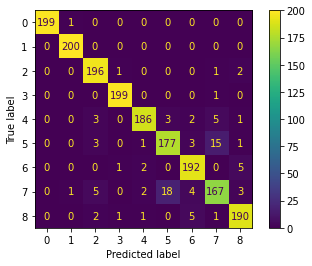

In [30]:
# evaluating model on full test dataset (may take time)
pred_2 = np.argmax(model.predict(d_test.images.astype('float32')/255.0), axis=1)
Metrics.print_all(d_test.labels, pred_2, 'test')

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1-bPLSa9urYVo3TMSi9dHRq-Oi1n1ogL1
To: /content/worst.pickle
100%|██████████| 172M/172M [00:00<00:00, 189MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 178MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.
3/3 [==============================] - 2s 511ms/step
metrics for test-tiny:
	 accuracy 0.9556:
	 balanced accuracy 0.9556:
	 precision 0.9613:
	 recall 0.9556:


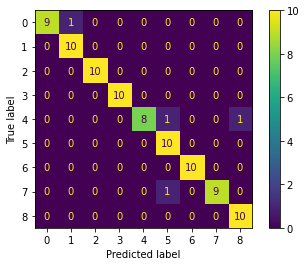

In [31]:
output = 'worst.pickle'
gdown.download(f'https://drive.google.com/uc?export=download&confirm=pbef&id=1-bPLSa9urYVo3TMSi9dHRq-Oi1n1ogL1', output, quiet=False)
with open('worst.pickle', 'rb') as f:
  final_model = pickle.load(f)
#final_model.load_('worst')
d_test_tiny = Dataset('test_tiny')
preds = np.argmax(final_model.predict(d_test_tiny.images.astype('float32')/255.0), axis=1)
Metrics.print_all(d_test_tiny.labels, preds, 'test-tiny')

Отмонтировать Google Drive.

In [30]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru. 

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb 

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"